# Learn on Chr1 Human

In [59]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import torch
from crossevopred.src.model.dummy_model import DummyModel
from crossevopred.src.model.trainer import Trainer
from crossevopred.utils.data_processing_utils import *
from crossevopred.src.data.dataset import ExpressionDataset
from crossevopred.src.data.encoder import *
from crossevopred.utils.plots import *
import yaml
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
from matplotlib.ticker import FuncFormatter
from torch.utils.data import DataLoader, ConcatDataset
import os


warnings.filterwarnings('ignore')
sns.set_theme(style="ticks")
plt.rcParams['figure.figsize'] = [2, 2]

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
# load pickle file
model_path = "../out/models/model.pkl"
trainer_path = "../out/models/model_trainer.pkl"
# load model
model = torch.load(model_path)
model = DummyModel()
model.load_state_dict(torch.load(model_path))
# load trainer 
with open(trainer_path, "rb") as file:
        trainer =  pickle.load(file)

In [ ]:
training_set = len(trainer.training_loader)


## Number of sequences in each set 

In [87]:
# number of lines in the file with bash and save the result in a variable
train_size = ! wc -l ../out/data/dataset/split_bed/chr1_train.bed
train_size = int(train_size[0].split(" ")[0])

val_size = ! wc -l ../out/data/dataset/split_bed/chr1_validation.bed
val_size = int(val_size[0].split(" ")[0])

test_size = ! wc -l ../out/data/dataset/split_bed/chr1_test.bed
test_size = int(test_size[0].split(" ")[0])

# extract length of each sequence - we can assume it's all the same
# get it from the first sequence in the training set bed file
# subract of 2nd column from 3rd column
seq_length = ! awk 'NR==1 {print $3-$2}' ../out/data/dataset/split_bed/chr1_train.bed

def plot_set_sizes(train_size, val_size, test_size, palette=None, seq_length=None): 
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    if palette is None:
        palette = sns.color_palette("Set2", 3)  # Using Seaborn's "husl" palette with 2 colors
    # stack train and val and on the side test
    ax.bar("Train & Validation", val_size, color=palette[1], label="Validation")
    ax.bar("Train & Validation", train_size , bottom = val_size, color=palette[0], label="Train")
    ax.bar("Test", test_size, color=palette[2], label="Test")  # Test color same as Train
    ax.set_ylabel("# of sequences")
    ax.set_title("Number of sequences in each set")
    # sequence length on the top
    if seq_length is not None:
        ax.set_title(f"Number of sequences in each set\nSequence length: {seq_length[0]}")
    ax.legend()
    # use K for thousands, so 1000 is 1K
   # Define a formatter function to format tick labels as 'K'
    def format_func(value, tick_number):
        return f'{value/1000:.0f}K'
    
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))  
    plt.show()


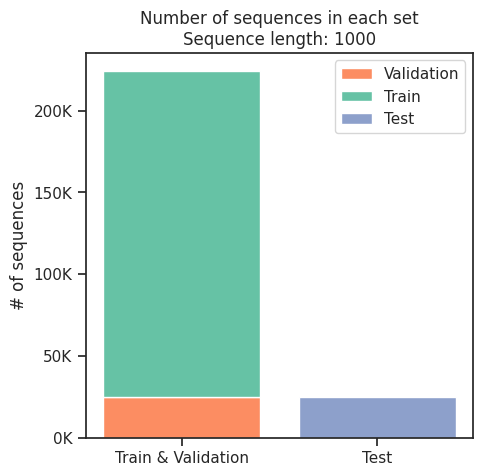

In [88]:
plot_set_sizes(train_size, val_size, test_size, seq_length=seq_length)

# Calculate the loss in the test set 

In [89]:
# iterate all files in test_dir with full path 
test_dir = "../out/data/dataset/objects/test"
test_dataset_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f))]
# Concat datasets - test dataset 
test_loader = None
for dataset in test_dataset_files:
    if test_loader is None:
        test_loader = torch.load(dataset)
    else:
        test_loader = ConcatDataset([test_loader, torch.load(dataset)])
test_loader = DataLoader(test_loader, batch_size=1, shuffle=True)

['../out/data/dataset/objects/test/chr1_test-sequences-and-labels_01.pth',
 '../out/data/dataset/objects/test/chr1_test-sequences-and-labels_00.pth']

In [ ]:
test_losses = trainer._evaluate_loss(test_loader,"corrcoef", all_losses=True)

In [214]:
# extract the average label from the test_loader 
mean_test_labels = []
for i, data in enumerate(test_loader):
    mean_test_labels.append(np.mean(data[1].numpy()))

### Check if the correlation coefficient is decent in the test set

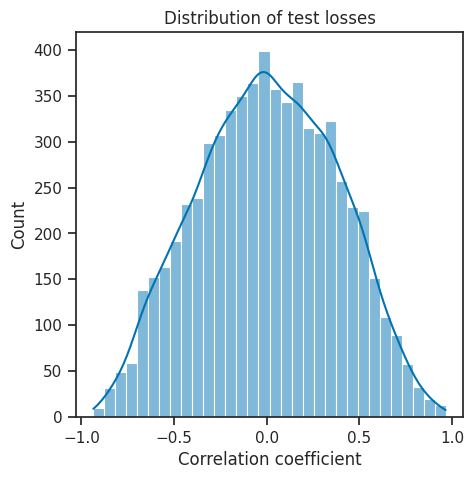

In [139]:
# Distribution of test losses, displot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.histplot(test_losses, kde=True, ax=ax)
ax.set_title("Distribution of test losses")
ax.set_xlabel("Correlation coefficient")
plt.show()

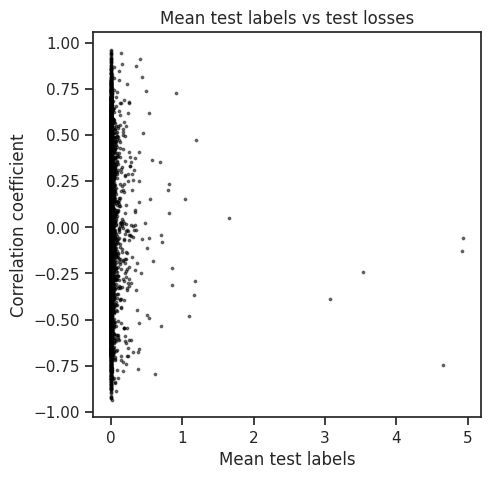

In [223]:
# plot mean test labels vs test losses
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(mean_test_labels, test_losses, s = 3, alpha=0.5, color="black")
ax.set_title("Mean test labels vs test losses")
ax.set_xlabel("Mean test labels")
ax.set_ylabel("Correlation coefficient")
plt.show()

### Check how the loss in the training went

<Axes: title={'center': 'Loss vs epoch'}, xlabel='epoch', ylabel='loss'>

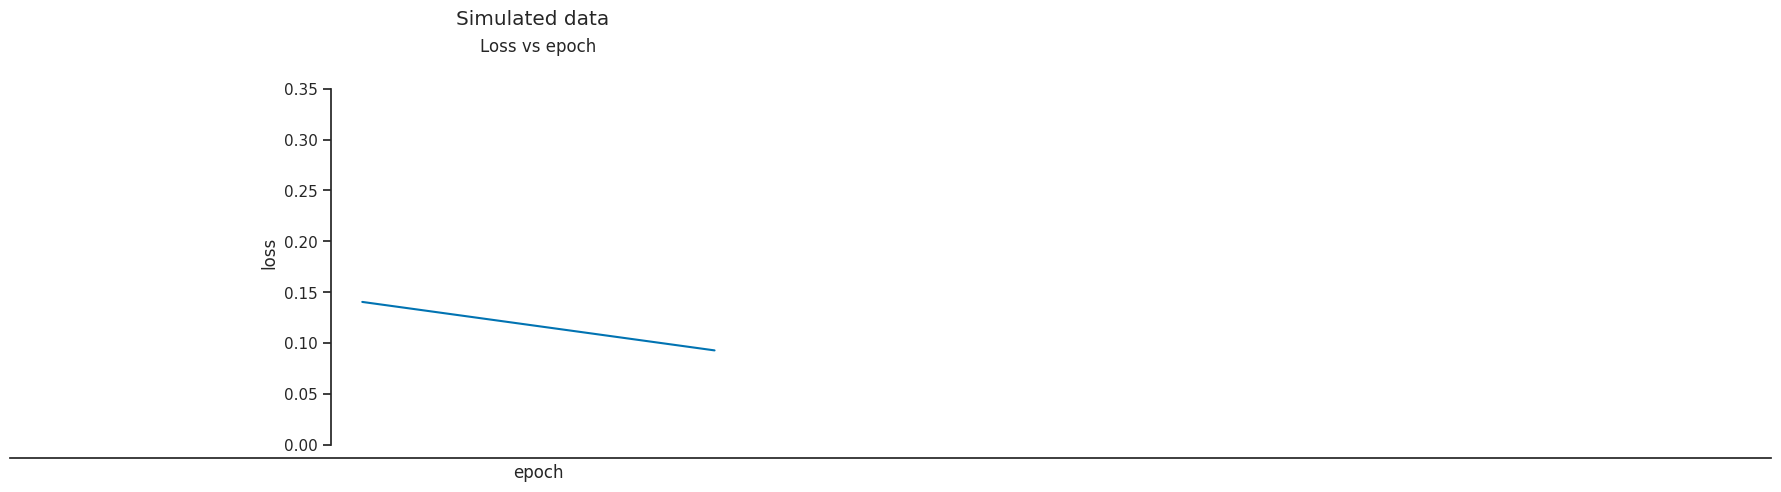

In [110]:
# Plots 
sns.set_palette("colorblind")
plot_loss_vs_epoch(trainer.training_infos, "Simulated data", "Loss vs epoch")

## Check a couple of examples

In [218]:
# take the example number 100 from the test set
for i in range(101):
    example = next(iter(test_loader))
# get the sequence
example_seq = example[0]
# decode the sequence
encoder = DNAEncoder()
example_seq = encoder.decode_one_hot(example_seq.squeeze())
# get the expression
example_expr = example[1]
# predict the expression
example_pred = model(example[0])

In [219]:
example_pred

tensor([[-2.9397, -3.7172, -4.4503, -3.4542, -3.5018, -4.2031, -3.9906, -2.3804]],
       grad_fn=<AddmmBackward0>)

In [210]:
example_expr

tensor([[0.0721, 0.0610, 0.0568, 0.0566, 0.0323, 0.0310, 0.0294, 0.0295]])

In [216]:
len(mean_test_labels)

20000